In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, \
                            r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [3]:
dataset = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'], index_col = "Date")

## Split to training and testing set

In [ ]:
# train-test 0.8/0.2
tstart = "2010-07-18"
tend = "2022-02-10"

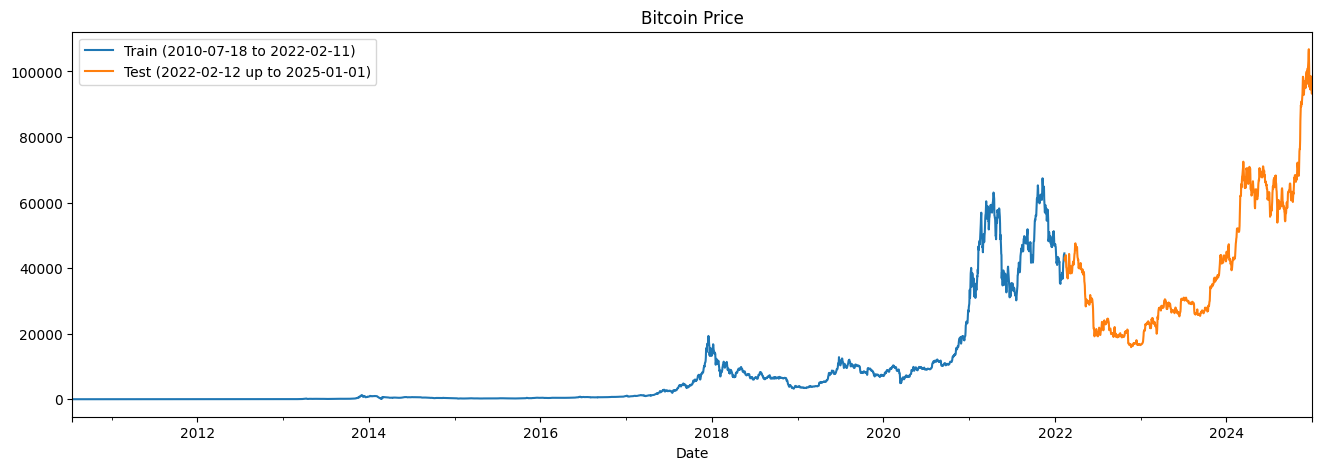

In [28]:
def train_test_plot(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    dataset.loc[tstart:tend, "Average"].plot(figsize=(16, 5), legend=True)
    dataset.loc[tend_next:, "Average"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train (2010-07-18 to {tend_next.date()})", f"Test ({tend_next.date() + pd.Timedelta(days=1)} up to 2025-01-01)"])
    plt.title("Bitcoin Price")
    plt.show()

train_test_plot(dataset, tstart, tend)

In [11]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "High"].values
    test = dataset.loc[tend_next:, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

## Normalize data

In [12]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [14]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

## Baseline LSTM

In [15]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 10 min
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0062
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 8.1118e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 5.3675e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 4.1634e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 3.4622e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 2.9998e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 2.6726e-04
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - loss: 2.4296e-04
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 2.2426e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 2.0946e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - loss: 1.9747e-04
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - loss: 1.8758e-04
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 1.7929e-04
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms

In [17]:
dataset_total = dataset.loc[:, "Average"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [33]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [ ]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100
    
    print(f"The root mean squared error is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")

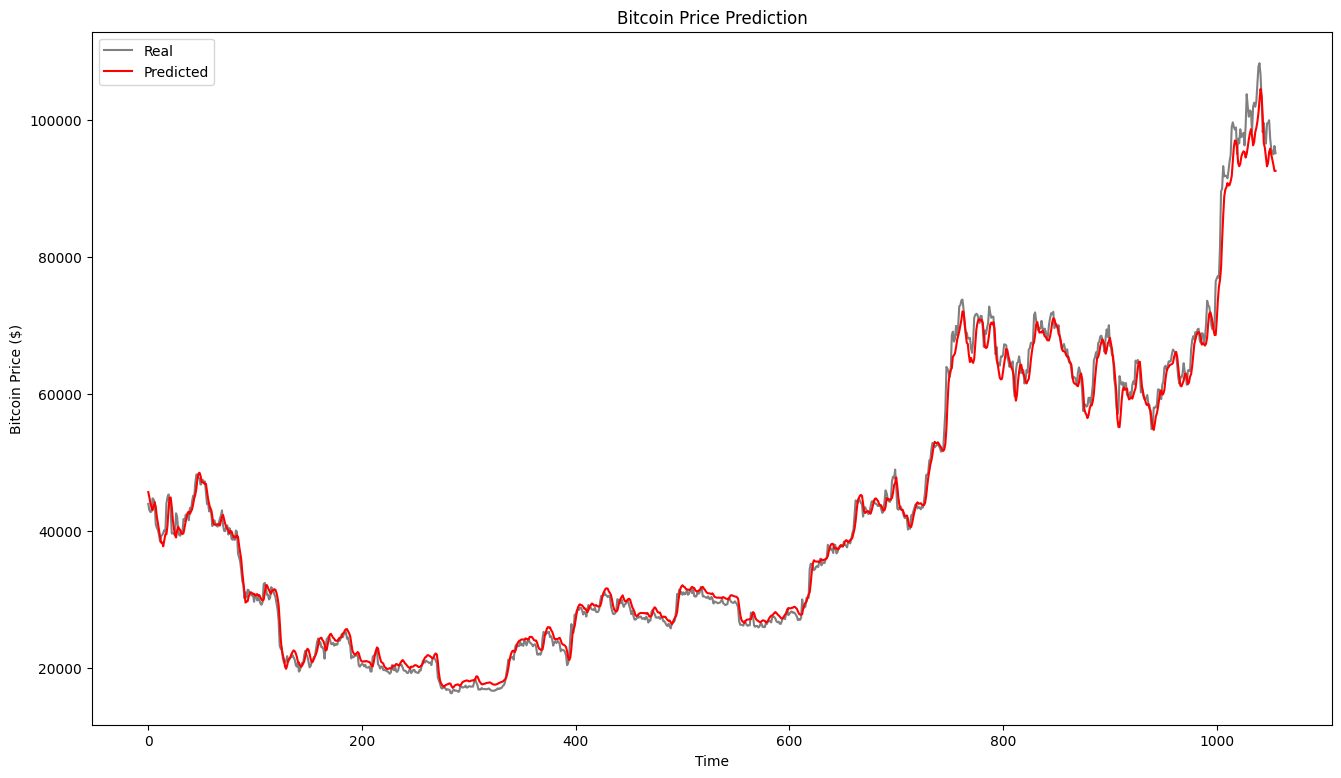

In [34]:
plot_predictions(test_set, predicted_stock_price)

In [21]:
# RMSE represents the square root of the variance of the residuals
# it may seem to be pretty high but considering the order of magnitude, I think it is pretty precise
print('Baseline LSTM Model:\n')
evaluate_model(test_set, predicted_stock_price)

The root mean squared error is 1659.64.


## Baseline GRU

In [29]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# 10 min
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0080
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 4.5454e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 3.6111e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 3.0172e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 2.6116e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 2.4074e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 2.2886e-04
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 2.2185e-04
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 2.2394e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 2.1655e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 1.9622e-04
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.8313e-04
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 1.7430e-04
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step -

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


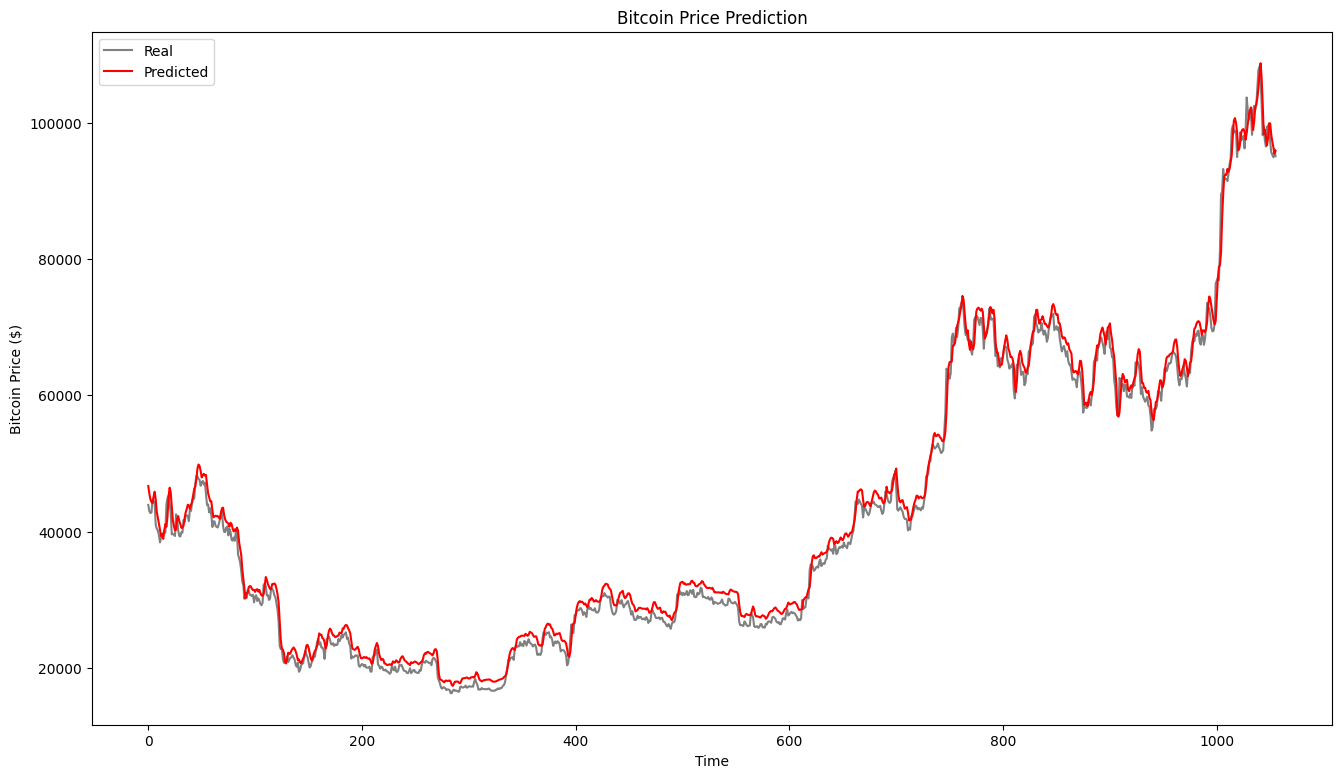

In [35]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

### Short Comparison

We can compare these two charts and conclude that the **GRU** model is more accurate in predicting latest (higher) prices and ramps up the lower prices at the earlier periods (especially where Time between 200 and 600). The RMSE here is still less, probably because the higher prices have smaller residuals, overshadowing poorer performance earlier (in Time).

On the other hand, **LSTM** is more precise in predicting earlier price movements (compare Time between 200 and 600), whereas it is less robust in identifying the most recent trends.

In [36]:
# Improved a bit with GRU
print('Baseline GRU Model:\n')
evaluate_model(test_set, GRU_predicted_stock_price)

The root mean squared error is 1609.76.


To improve models & RMSE:
- increase `batch_size`
- increase or decrease `n_steps` in **split_sequence**
- train more epochs
- improve model structure (especially GRU)
- reducing dataset (e.g. start from 2017)
- separate normalization over different time windows
- extend `train_set` (e.g. to 0.85)
- try various activation functions